# Week 3 - Simple Classification

Welcome to the first exercise session. Here you will get your hands on _real physics data_ and turn your hand to training a classifier!

Classification is the bread and butter of modern machine learning, and the same goes for a lot of applications in physics.

In this session you will play with the "flavour tagging" dataset from the ATLAS Detector at the LHC.

## The dataset

At the ATLAS detector one of the signatures for interesting physics is the presence of B hadrons produced in collisions. Unforunately these hadrons are relatively short lived and decay after a maximum of a couple of centimetres in the detector, and so are not detected directly. The remnants of their decay and other products from the collisions are reconstructed as big showers of energy and tracks in the detector - we call them "jets".

In flavour tagging, the goal is to identify which jets came from B hadrons (or D hadrons) and which were just produced from light quarks or gluons.

In todays dataset we have provided you with several observables that can be reconstructed from the tracks in a jet. You will use these variables to identify which jets are interesting!

## A classifier

The basic building blocks of most networks are linear, or dense, layers. These layers are a series of "nodes" which are connected to all inputs of the previous layer (each input feature is treated as a node), plus an additional bias node. Each layer is formed by a learned weight matrix ($W$), plus a bias ($b$). If the input vector is of dimension $n$ and the first layer of the model is set to have $m$ nodes, then $W$ will be an $n$ by $m$ matrix, and $b$ will be a $m$ dimensional vector. The input $x$ is then transformed by simple matrix multiplcation.

$W x + b.$

After the matrix multiplication the nodes are passed through an "activation" layer, this is where we can introduce non-linearities! This activation layer is a simple transformation of the output node. Finally, all nodes can be used as inputs to the next layer.

At the end of the network you will put an output layer. Here you have either:
* 1 output node (for a binary task)
* N output nodes (for a multiclass task)

A network of linear layers with internal activations $f_1$ and output activation $f_2$ look like this

$l_1 = f_1(W_1 x + b_1) \\
l_2 = f_1(W_2 l_1 + b_2) \\
... \\
l_n = f_2(W_n l_{n-1} + b_n)
$

At the output we apply the loss function to measure how far away from the truth the predictions are. 

We then calculate the gradient of all the weights in the network with respect to the loss function, using the chain rule and backpropagation with gradient descent to update them.

If we have every prediction correct, we will be at the minimum value of this loss, and all gradients will be zero. But if we could do better, our gradient will tell us in which direction we need to move to reach the minimum.

Simple!

## But it's not that simple

Unfortunately it isn't that simple to train a good classifier, they are very susceptible to biases and overfitting to your training dataset. Just like fitting a curve to a handful of datapoints, if you use a 10 degree polynomial you will have a better statistical agreement to your data, but likely you won't generalise well to extra datapoints.

We need to design the architecture around being general, robust, and avoiding bias.

## Task 1
We are now going to build, train and evaluate a simple classifier.

### The data
All machine learning tasks start with the data, and the way the data is presented to the model is often one of the most important consideration when training a machine learning model. There are many things to take into consideration with respect to the data, and we will discuss this more as the course goes on. For now, there is no need to worry about this too much.

In the following we will load some data, visualise it, and then prepare it for use with our classifier.

In [99]:
import pandas as pd
data = pd.read_hdf('data/simple_btag.h5', key='/scaleshift')

PY note: ```key: object, optional``` The group identifier in the store. Can be omitted if the HDF file contains a single pandas object.

The data is stored with each column as a feature that can be exploited for training a model, and each row as a different event/measurement. In this introduction we aren't going to worry much about what the specific features are, so don't worry about the names of the columns for now.

In [100]:
data.head()

,IP3D_pu,IP3D_pc,IP3D_pb,SV1_masssvx,SV1_efracsvx,SV1_significance3d,JetFitterSecondaryVertex_mass,JetFitterSecondaryVertex_energy,JetFitterSecondaryVertex_energyFraction,label
0,-0.358933,-0.298392,-0.225777,-0.546597,NaN,-0.837479,-1.201001,-0.986476,-0.035497,0
1,-0.254308,0.017511,-0.137013,-0.456101,NaN,-0.191352,-0.856183,-0.841605,-0.523683,0
2,-0.253749,-0.127833,-0.197234,-0.539321,NaN,-0.394342,-0.838740,-0.804247,-0.401338,0
3,-0.303304,0.054879,0.000053,-0.458057,NaN,-0.446057,-0.304897,-1.016424,-0.514472,0
4,-0.365905,-0.169577,-0.170747,-0.485272,NaN,-0.837479,-0.571022,-0.429983,-0.514671,0


PY note:
```data.head()``` Returns first 5 lines by default. Read more here: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.head.html

Now we can do some simple data cleaning to remove all NaNs from the data, this is necessary because we can't use NaN values in ML. Sometimes, when NaN values represent missing features, and appear infrequently, it can be useful to replace these values with zeros (or another sensible scalar), but here we will simply remove them from our dataset.

In [101]:
data = data.dropna(axis=1)

PY note:
```axis``` {0 or ‘index’, 1 or ‘columns’}, default 0
Determine if rows or columns which contain missing values are removed.
- 0, or ‘index’ : Drop rows which contain missing values.
- 1, or ‘columns’ : Drop columns which contain missing value.

Now let's see how many features and data points we are training with.

In [102]:
print(f'There are {data.shape[0]} training samples, and {data.shape[1]} training features.')

There are 100000 training samples, and 9 training features.


Now let's plot all of the features that we have access to

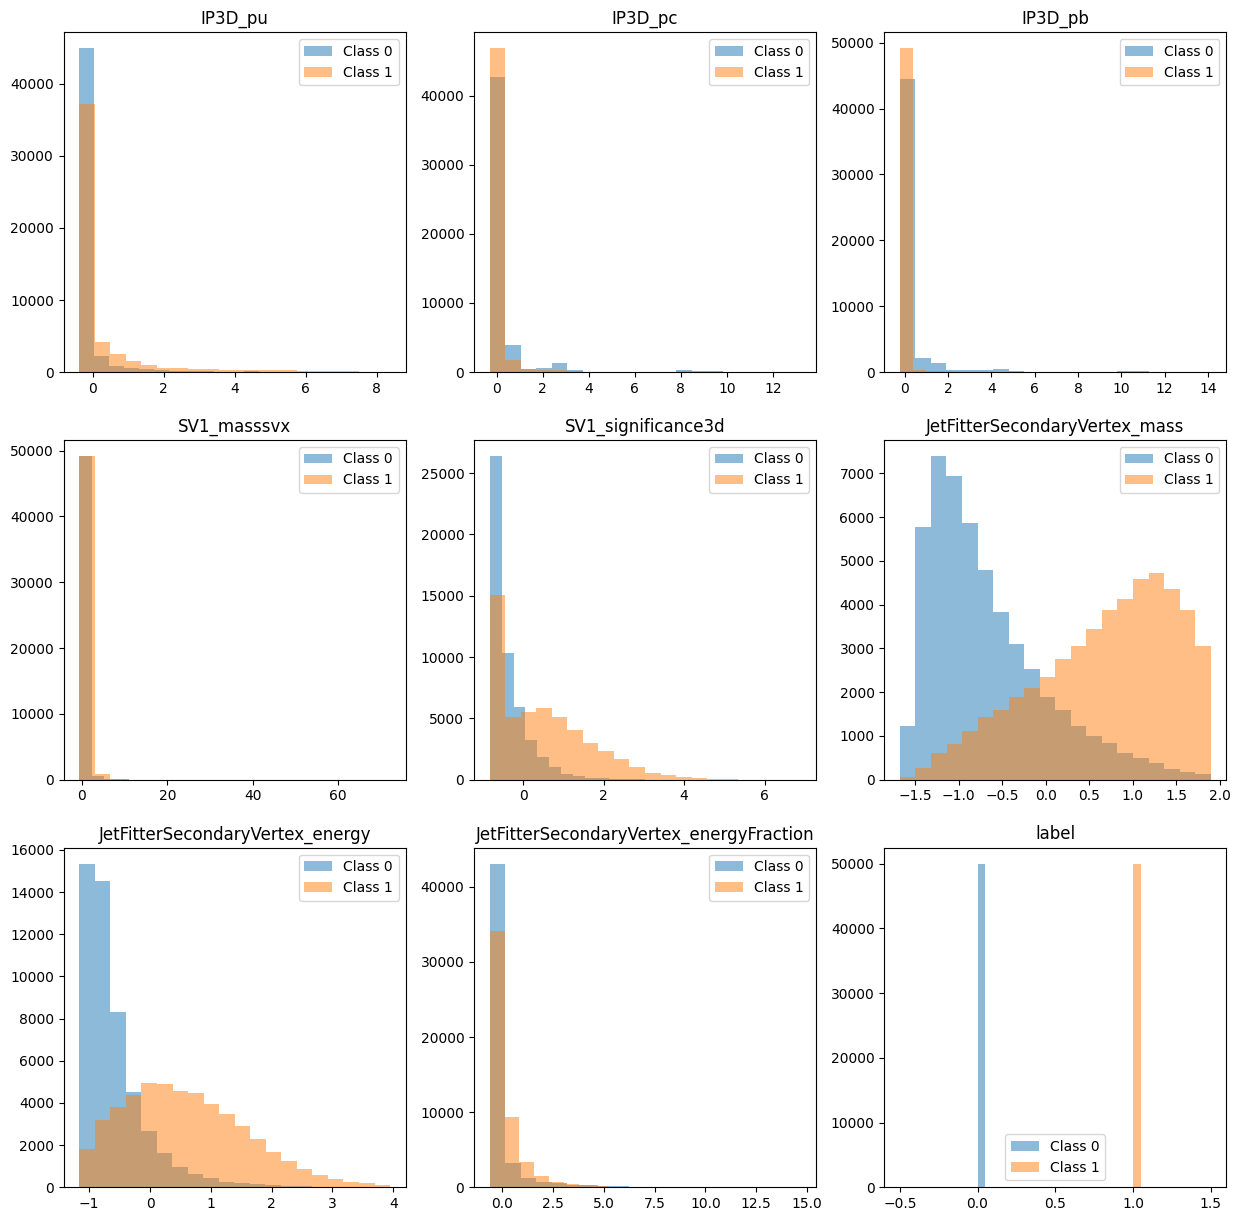

In [27]:
import matplotlib.pyplot as plt
#import numpy as np
fig, _ = plt.subplots(3, 3, figsize=(15,15))
axes = fig.axes
#fig, axes = plt.subplots(3, 3, figsize=(14,14)) # test on accessing the axes in a diff way ...
class_0 = data.loc[data['label'] == 0]
class_1 = data.loc[data['label'] == 1]
for i, ax in enumerate(axes):
#for i, ax in np.ndenumerate(axes): # ... does not work
    ax.hist(class_0.iloc[:, i], bins=20, label='Class 0', alpha=0.5)
    ax.hist(class_1.iloc[:, i], bins=20, label='Class 1', alpha=0.5)
    ax.legend()
    ax.set_title(data.columns[i])
plt.show()
fig.clf()

PY note:
Dataframe ```loc``` is crazy tool https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.loc.html

In [24]:
for i, ax in enumerate(axes):
    print(i,ax)

0 AxesSubplot(0.125,0.653529;0.227941x0.226471)
1 AxesSubplot(0.398529,0.653529;0.227941x0.226471)
2 AxesSubplot(0.672059,0.653529;0.227941x0.226471)
3 AxesSubplot(0.125,0.381765;0.227941x0.226471)
4 AxesSubplot(0.398529,0.381765;0.227941x0.226471)
5 AxesSubplot(0.672059,0.381765;0.227941x0.226471)
6 AxesSubplot(0.125,0.11;0.227941x0.226471)
7 AxesSubplot(0.398529,0.11;0.227941x0.226471)
8 AxesSubplot(0.672059,0.11;0.227941x0.226471)


From this we can see that different features have different amounts of separation power for distinguishing between our two classes. We can take as many of these features as we want (except the labels) to train our classifier, but to start off with we will take just two.

We will also grab the labels of the data, as these are required as targets when training our model.

In [25]:
# First we shuffle the data to ensure when we split the data different labels will be properly represented
data = data.sample(frac=1)
samples = data[['JetFitterSecondaryVertex_mass', 'JetFitterSecondaryVertex_energy']]
labels = data['label'] # What do these labels mean? --> gives the target values 

In [38]:
 data

,IP3D_pu,IP3D_pc,IP3D_pb,SV1_masssvx,SV1_significance3d,JetFitterSecondaryVertex_mass,JetFitterSecondaryVertex_energy,JetFitterSecondaryVertex_energyFraction,label
1250,0.059830,0.540749,0.198839,-0.159050,-0.038596,0.618936,-0.732656,-0.528845,0
38792,-0.338071,-0.216665,-0.221885,-0.558093,-0.837479,-0.780285,-0.983482,-0.562962,0
99154,-0.349815,-0.311932,-0.226933,-0.184569,0.887873,0.147831,-0.086611,0.240377,1
88977,-0.358134,-0.312517,-0.226932,0.101371,0.543866,1.451941,1.504500,-0.126413,1
28819,-0.378128,-0.296690,-0.221012,1.282521,-0.837479,0.287395,-0.540445,-0.591770,0
...,...,...,...,...,...,...,...,...,...
38264,-0.273843,-0.027751,-0.001258,-0.566197,-0.639605,-1.303054,-1.150798,-0.612128,0
54008,6.957781,-0.051897,-0.225248,0.807394,0.614615,1.639378,2.379431,4.456573,1
75864,-0.378436,-0.309284,-0.226353,0.419115,2.120891,0.243595,0.930973,-0.473208,1
63078,-0.372294,-0.311529,-0.226933,0.951693,2.087932,1.465957,0.760121,0.188064,1


PY note:

```DataFrame.sample```: Return a random sample of items from an axis of object.


- ```n```: (int, optional) Number of items from axis to return. Cannot be used with ```frac```. Default = 1 if ```frac``` = None.
- ```frac```: (float, optional) Fraction of axis items to return. Cannot be used with ```n```.
- ```axis``` {0 or ‘index’, 1 or ‘columns’, None}, default None. Axis to sample. Accepts axis number or name. Default is stat axis for given data type (0 for Series and DataFrames).

The last thing we need to do with the data is split it into training and validation sets, we will then be ready to fit a model to our data.

The training data is used to tune the parameters of our machine learning model, and the validation data is used to check that the model can generalise to data it has never seen before.

In [34]:
samples

,JetFitterSecondaryVertex_mass,JetFitterSecondaryVertex_energy
1250,0.618936,-0.732656
38792,-0.780285,-0.983482
99154,0.147831,-0.086611
88977,1.451941,1.504500
28819,0.287395,-0.540445
...,...,...
38264,-1.303054,-1.150798
54008,1.639378,2.379431
75864,0.243595,0.930973
63078,1.465957,0.760121


In [39]:
# First we define the fraction of the training data we want to use for training
data_split = 0.5
n_data = data.shape[0]
# Now we calculate the number of samples we want to take for training
n_train = int(data_split * n_data)

# Now we split our data and labels into two different sets, one for validation, one for training
training_data = samples[:n_train]
validation_data = samples[n_train:]
training_labels = labels[:n_train]
validation_labels = labels[n_train:]

Now we have dealt with the data, let's build a classifier to train on it!

## Training a simple classifier

We have two class labels at the moment, and so we are going to make a binary classifier with a single output node.

First we need to set up our environment. For our classifier we will use tensorflow with the keras API, but feel free to use pytorch if you are more familiar with it.

In [40]:
import tensorflow as tf
import numpy as np
import utils

Neural networks/ML methods are based on models, these are just collections of parameters that can be tuned to fit a function to a specific problem, classification in this instance. 

Tensorflow provides us with a Model object that allows easy access to all of the parameters in a graph and methods for easily fitting a model to data, as we will see below.

In [41]:
from tensorflow.keras import Model

The basic building blocks of any ML model are layers, in this case we will be using simple linear layers with
restricted non-linearities. These are referred to as ```Dense``` layers in tensorflow.

The below code snippet will result in a single layer of a graph being built

```y = Dense(n_hidden_nodes, activation='relu')(x).```

The above function will correspond to 

```y = ReLU(M x + b)```

Where the non-linear activation ```ReLU``` will be applied elementwise, and ```M``` is a matrix with dim(```x```) columns and
dim(```y```) rows.

Tensorflow automatically tracks and builds a graph that points from inputs to outputs, this graph can be
composed of many layers, as we will see below.

In [42]:
from tensorflow.keras.layers import Dense

In [44]:
training_data.shape[1]

2

In [43]:
n_hidden_nodes = 32

# The input variables/nodes are special in tensorflow, and are defined as follows.
# Note that this input layer is defined by the number of input features in our training data
inputs = tf.keras.Input(shape=(training_data.shape[1],))

# We then construct a graph of different layers, you can add as many layers as you like here, but more layers
# doesn't always lead to better performance.
x = Dense(
    n_hidden_nodes, activation='relu'
)(inputs)
x = Dense(
    n_hidden_nodes, activation='relu'
)(x)

# Our output layer maps to a single node as we are doing binary classification. This single output variable 
# defines the prediction of our neural networks.
outputs = Dense(
    1, activation='sigmoid' 
)(x)

# We have now defined a graph from inputs to outputs, this graph is composed of several Dense layers, all of which
# have trainable/learnable parameters. To access these parameters for easy optimization we build a Model object.
model = Model(inputs=inputs, outputs=outputs)

Now we have defined a neural network model and loaded/explored our data. The last ingredients we need are
an optimizer and a loss function. 
Tensorflow provides access to many different kinds of optimizers, but here we will use the Adam
optimizer, a choice that tends to work well in many different settings.

In [47]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

The above object can be used to update the parameters/weights of our model object. This update is done based on
the gradients of the loss function of our model with respect to each parameter of the model.
The 'step size' of these gradient updates is defined by the learning rate, which is the only parameter of
the optimizer we will worry about for now.

Next we can compile our model with the above optimizer and also define a loss function. The loss function measures the discrepancy between the output of the network and the targeted value.

Here 'bce' stands for binary cross entropy.

In [48]:
model.compile(optimizer, loss='bce')

Now let's fit the model to the training data we chose earlier.
Here we need to specify the training data and the target, which is given by the training label.

When training the model we need to specify ```epochs```, which is the number of times the dataset is cycled through, and ```batch_size```, which is the number of samples used to calculate each gradient update.

In [53]:
history = model.fit(training_data, training_labels, epochs=5, batch_size=32, 
                    validation_data=(validation_data, validation_labels))

Epoch 1/5
1563/1563 [==============================] - 4s 3ms/step - loss: 0.3879 - val_loss: 0.3853
Epoch 2/5
1563/1563 [==============================] - 4s 3ms/step - loss: 0.3881 - val_loss: 0.3866
Epoch 3/5
1563/1563 [==============================] - 4s 3ms/step - loss: 0.3879 - val_loss: 0.3847
Epoch 4/5
1563/1563 [==============================] - 4s 3ms/step - loss: 0.3881 - val_loss: 0.3859
Epoch 5/5
1563/1563 [==============================] - 4s 3ms/step - loss: 0.3880 - val_loss: 0.3841


We can make a simple function for plotting the evolution of the validation and training losses as a
a function of the number of epochs.

In [50]:
def plot_losses(history):
    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

The two losses we see in this plot show the performance of the model on the classification task as a function of the number of epochs. The two losses should be very similar to get good performance with our classifier. The performance of the model will be defined by it's performance on the validation loss as this is the data the model is not optimised on!

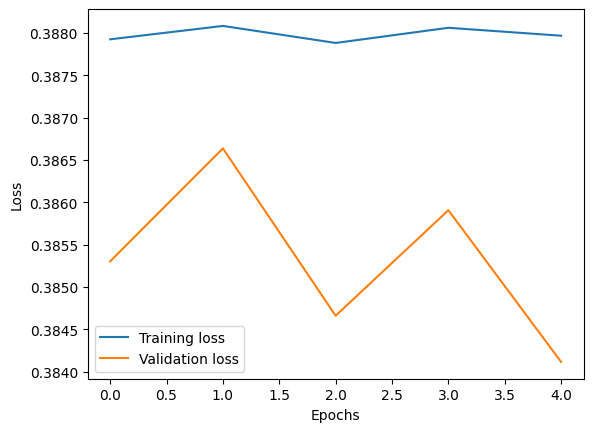

In [54]:
plot_losses(history)

Now we have trained a model on our training data, but it has never seen the validation data before.
How well can the model, which has only ever seen the training data, predict the labels of the validation data?
Getting the predictions from our model is very easy with the tensorflow API.

In [56]:
predictions = model.predict(validation_data)

To visualise the models performance, we can see how the labels are distributed

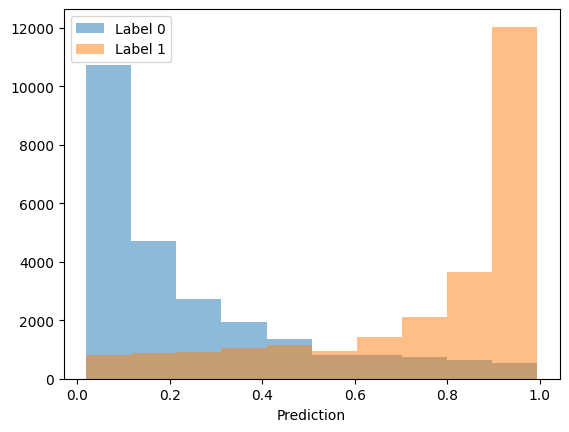

In [57]:
def visualise_predictions(predictions):
    # This will just cast our predictions to floats
    predictions = np.array(predictions, dtype=np.float32)
    fig, ax = plt.subplots()
    ax.hist(predictions[validation_labels == 0], label='Label 0', alpha=0.5)
    ax.hist(predictions[validation_labels == 1], label='Label 1', alpha=0.5)
    ax.legend()
    ax.set_xlabel('Prediction')
    plt.show()
    fig.clf()
    
visualise_predictions(predictions)

The above plot shows how our models predictions are distributed, note that the output is in [0, 1], this is 
because we chose a sigmoid activation function for the output of our model.
Also, note that the predictions for each label are peaked around the correct values, input data from label 1
is much more commonly assigned higher values than input data associated with label 0. This means that our model
has learned to classify the data well, but how accurate are our predictions?
To turn the output of our classifier into a class label we need to apply a threshold to the output of the 
classifier. So, for example, let's take 0.5.

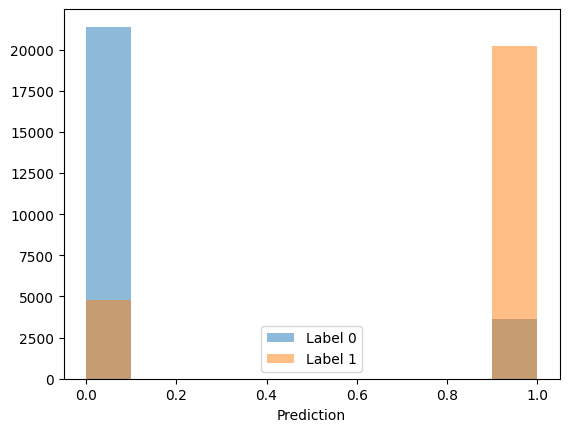

In [58]:
threshold = 0.5
# Applying this threshold will give us a zero where the classifier predicts values less than 0.5
label_prediction = predictions > threshold
# Now let's see how our binary predictions are distributed
visualise_predictions(label_prediction)

We can repeat this process for a different threshold

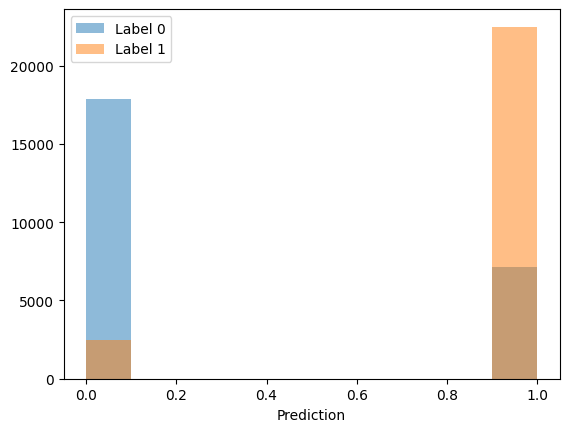

In [59]:
threshold = 0.3
label_prediction = predictions > threshold
visualise_predictions(label_prediction)

And the associated binary labels have changed. We can pick any number between zero and one as the 
threshold for the classifier. But which threshold should we choose? And how do we characterise the performance
of the classifier overall?
Perhaps the most obvious thing to check might be the accuracy of the classifier at a given threshold, let's 
look at the accuracy as a function of threshold

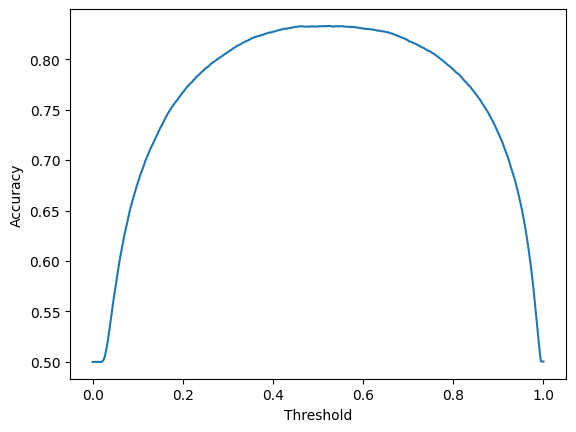

In [60]:
thresholds = np.linspace(0, 1, 1000)
accuracies = np.sum(
    (predictions > thresholds) == validation_labels.to_numpy().reshape(-1, 1),
    axis=0) / len(validation_labels)
plt.plot(thresholds, accuracies)
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.show()

In the setting where have trained our model the accuracy is useful for quantifying the performance as the classes are balanced
ie) there are as many examples of class 0 as there are of class 1. However, this is not typically the case, and
if the classes are not balanced then a classifier that always predicts the majority class can still have a high
accuracy.

In [61]:
# Count the number of true and false labels
n_true = np.sum(validation_labels)
n_false = np.sum(1 - validation_labels)
print(f'There are {n_true} examples of label 1 and {n_false} of label 0.')

There are 24990 examples of label 1 and 25010 of label 0.


It is much more useful to look at the reciever operator curve (ROC) to gauge the performance of a classifier.
The reciever operator curve looks at the false positive rate vs the true postitive rate, parameterised by 
the threshold value. We will calculate it below to demonstrate how this is calculated.

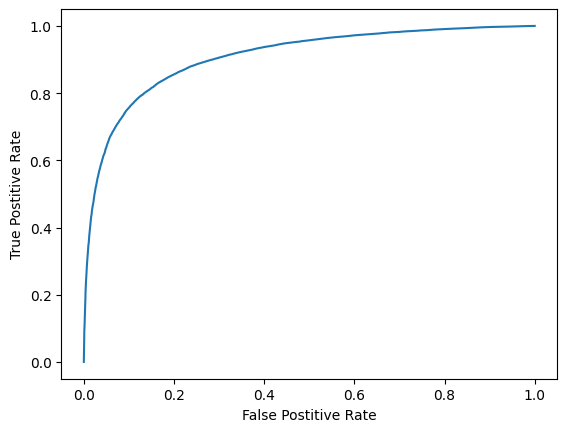

In [65]:
# If you aren't interested in the specific details of how a ROC curve is generated, there is no need to read this
# cell too closely.
thresholds = np.linspace(0, 1, 1000)
# Get the predictions at all values defined in the above array
binary_predictions = (predictions > thresholds) == validation_labels.to_numpy().reshape(-1, 1)
# Get the true positive rate with simple counting
true_positive_rates = np.sum(binary_predictions[validation_labels == 1] == 1, axis=0) / n_true
# Expand the true values to match the shape of the binary_predictions array
expanded_truths = validation_labels.to_numpy().reshape(-1, 1).repeat(1000, axis=1)
# Build an array that is nonzero only where the classifier predicts true values, and see how many are really false
false_positive_rates = np.sum(np.array(
    np.ma.array(expanded_truths, mask=binary_predictions == 1) == 0), 
    axis=0) / n_false
# Plot the ROC curve
plt.plot(false_positive_rates, true_positive_rates)
plt.ylabel('True Postitive Rate')
plt.xlabel('False Postitive Rate')
plt.show()

PY note/question:
    Wtf is happening above in ```expanded_truths``` and what is ```repeat``` and ```np.ma```?

The above is just intended to demonstrate how the ROC curve is parameterised by the threshold. In practise the
scikit learn library provides a much simpler implementation. We can build a function to easily plot these ROC curves and calculate the area under it.

In [70]:
predictions

array([[0.06428912],
       [0.21118078],
       [0.78175884],
       ...,
       [0.8612769 ],
       [0.96586215],
       [0.24468464]], dtype=float32)

In [73]:
validation_labels

10499    0
19884    0
78642    1
3673     0
3582     0
        ..
38264    0
54008    1
75864    1
63078    1
91821    1
Name: label, Length: 50000, dtype: int64

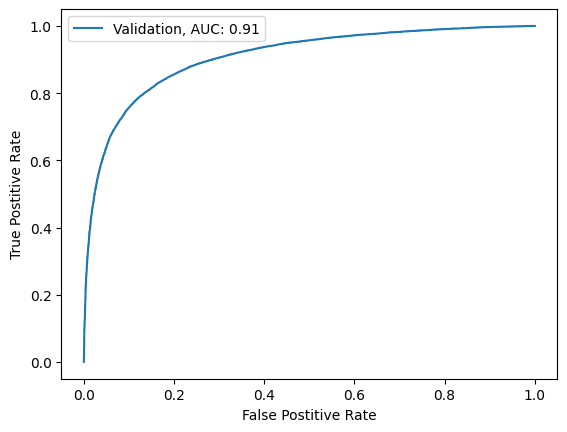

In [66]:
from sklearn.metrics import roc_curve, auc
def plot_roc(predictions, labels, label='Validation'):
    fpr, tpr, _ = roc_curve(labels, predictions)
    # Scikit learn also allows us to calculate the area under this curve. This measure of classifier performance 
    # is very useful for quantifying performance and is independent of any threshold value.
    
    # How is it independent of any threshold value?
    # It was dependent on it before.
    # What the is "default" threshold value for "roc_curve"?
    
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{label}, AUC: {roc_auc:.2f}')
    plt.ylabel('True Postitive Rate')
    plt.xlabel('False Postitive Rate')
    plt.legend()
    
plot_roc(predictions, validation_labels.to_numpy())
plt.show()

PY note

SKLearn ```roc_curve``` return values:

- ```fpr``` : ndarray of shape (>2,)
    Increasing false positive rates such that element i is the false positive rate of predictions with score >= thresholds[i].
- ```tpr``` ndarray of shape (>2,)
    Increasing true positive rates such that element i is the true positive rate of predictions with score >= thresholds[i].
- ```thresholds``` ndarray of shape = (n_thresholds,)
    Decreasing thresholds on the decision function used to compute fpr and tpr. thresholds[0] represents no instances being predicted and is arbitrarily set to max(y_score) + 1.

## Now you try

In the following try to increase the performance of this simple classifier. It is possible to get an AUC of 0.92 or above on this problem on the validation set, so try to aim for that!

In [103]:
data = data.sample(frac=1) 
data_split = 0.5 # 0.3, 0.7, doesn't make a difference
n_data = data.shape[0]
n_train = int(data_split * n_data)
labels = data['label']
samples = data[['IP3D_pu', 'IP3D_pc', 'IP3D_pb']]
labels = data['label']

training_data = samples[:n_train]
validation_data = samples[n_train:]
training_labels = labels[:n_train]
validation_labels = labels[n_train:]

Epoch 1/5
1563/1563 [==============================] - 5s 3ms/step - loss: 0.4752 - val_loss: 0.4411
Epoch 2/5
1563/1563 [==============================] - 5s 3ms/step - loss: 0.4339 - val_loss: 0.4245
Epoch 3/5
1563/1563 [==============================] - 5s 3ms/step - loss: 0.4253 - val_loss: 0.4149
Epoch 4/5
1563/1563 [==============================] - 5s 3ms/step - loss: 0.4183 - val_loss: 0.4045
Epoch 5/5
1563/1563 [==============================] - 5s 3ms/step - loss: 0.4143 - val_loss: 0.4097


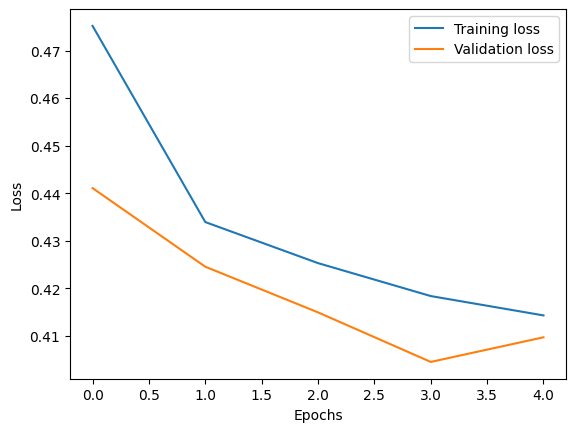

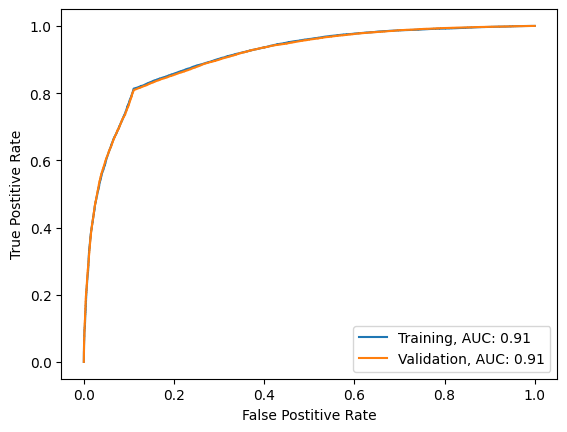

In [106]:
n_hidden_nodes = 32 # tried 48, 50, 64 doesn't help
activation = 'relu' # previously "none", this is the only change that brought AUC=0.85 to 0.90
inputs = tf.keras.Input(shape=(training_data.shape[1],))
x = Dense(n_hidden_nodes, activation=activation)(inputs)
x = Dense(n_hidden_nodes, activation=activation)(x)
x = Dense(n_hidden_nodes, activation=activation)(x)
x = Dense(n_hidden_nodes, activation=activation)(x)
#x = Dense(n_hidden_nodes, activation=activation)(x # also tried only 2 layers
outputs = Dense(1, activation='sigmoid')(x)
model = Model(inputs=inputs, outputs=outputs)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001) # previously 0.01, brought AUC=0.90 to 0.91
model.compile(optimizer, loss='bce')
history = model.fit(training_data, training_labels, epochs=5, verbose=True, 
                    validation_data=(validation_data, validation_labels))

plot_losses(history)

valid_predictions = model.predict(validation_data)
train_predictions = model.predict(training_data)
  
plot_roc(train_predictions, training_labels.to_numpy(), label='Training')
plot_roc(valid_predictions, validation_labels.to_numpy(), label='Validation')
plt.show()
plt.clf()

## Overfitting

In the above we can see that the ROC curve for the training and validation data is very similar, but this isn't guaranteed to be the case. 

Sometimes we have very few training examples, or make a model that has too many parameters. Perhaps, in tuning the model above, you are now seeing a separation between training and validation data. This is undesirable behaviour, as the results we achieve on the validation set are a proxy for what we can expect to achieve on our real world data. How to select the settings (hyperparameters) of a machine learning model is something we will cover in more detail in later lectures.

In this next example we will load a new dataset and train a classifier, but the new data is more challenging to train on, and so it is easier to overfit.

In [108]:
from utils import load_data

In [109]:
data = load_data()

In [110]:
print(f'There are {data.shape[0]} training samples, and {data.shape[1]} training features.')

There are 100000 training samples, and 38 training features.


In [111]:
data.head()

,pt,eta,IP2D_pu,IP2D_pc,IP2D_pb,IP3D_pu,IP3D_pc,IP3D_pb,IP2D_nTrks,IP3D_nTrks,...,SV1_N2Tpair,SV1_NGTinSvx,SV1_masssvx,SV1_efracsvx,SV1_significance3d,SV1_dstToMatLay,SV1_deltaR,SV1_Lxy,SV1_L3d,label
3301777,-0.441306,-1.286666,-0.134907,-0.289657,-0.422052,-0.116104,-0.280253,-0.447875,1.064024,1.064024,...,2.048947,2.029992,-0.244079,0.821734,-0.433351,0.046935,-0.501623,-0.041438,0.148990,1
1186443,1.988958,-0.270916,-0.133603,-0.240551,-0.359785,-0.114904,-0.191541,-0.407811,-0.455815,-0.455815,...,-0.822760,-0.700664,-0.530523,0.789529,-0.277481,-0.635814,-0.437043,0.396675,-0.107518,0
3707147,-0.917472,1.409469,-0.117106,-0.238520,-0.416656,-0.101599,-0.222867,-0.447305,-0.075855,-0.075855,...,-0.104834,0.937729,-0.489187,0.718012,-0.718347,0.727664,0.329133,-0.636766,-0.421025,1
120734,0.535305,0.264206,-0.008991,0.321961,-0.049313,-0.063510,0.317373,0.281025,-1.215734,-1.215734,...,-0.463797,-0.700664,0.453309,0.306786,1.988908,-2.247694,-0.351775,1.493086,0.419511,1
2500361,-0.750744,1.166178,-0.134162,-0.096643,0.417220,-0.116073,-0.199442,1.430252,-0.835775,-0.835775,...,0.074648,-0.154533,0.481005,0.960995,-0.260608,0.666081,-0.179117,-0.468549,-0.350453,1


Now we have loaded the data, we again split it into training and validation sets

In [112]:
data = data.sample(frac=1) 
data_split = 0.5
n_data = data.shape[0]
n_train = int(data_split * n_data)
labels = data['label']
# This time we are going to take all of the features except for the label itself
samples = data.drop('label', axis=1)

training_data = samples[:n_train]
validation_data = samples[n_train:]
training_labels = labels[:n_train]
validation_labels = labels[n_train:]

We can write a function that takes as inputs the settings/hyperparameters of our machine learning model. Changing these parameters will change the performance of our classifier, and we will try and see which leads to good performance on both the training and validation datasets.

You should try to get a feel for how each of these parameters affects the performance, as measured by the AUC, of each model. For a first pass, just runs the cells as we have defined them.

In [113]:
# These are our hyperparameters, which you can change as you want to alter the models performance
activation='relu'
n_hidden_nodes=512
n_layers=3
learning_rate=0.001
batch_size=2000

In [114]:
# This is the block of code for building and training the model
inputs = tf.keras.Input(shape=(training_data.shape[1],))
x = Dense(n_hidden_nodes, activation=activation)(inputs)
for _ in range(n_layers):
    x = Dense(n_hidden_nodes, activation=activation)(x)
outputs = Dense(1, activation='sigmoid')(x)
model = Model(inputs=inputs, outputs=outputs)

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer, loss='bce')

Feel free to interrupt this training if you see the validation loss isn't improving

Epoch 1/15
25/25 [==============================] - 2s 80ms/step - loss: 0.2521 - val_loss: 0.1964
Epoch 2/15
25/25 [==============================] - 2s 68ms/step - loss: 0.1932 - val_loss: 0.1865
Epoch 3/15
25/25 [==============================] - 2s 68ms/step - loss: 0.1826 - val_loss: 0.1819
Epoch 4/15
25/25 [==============================] - 2s 64ms/step - loss: 0.1764 - val_loss: 0.1782
Epoch 5/15
25/25 [==============================] - 2s 63ms/step - loss: 0.1708 - val_loss: 0.1812
Epoch 6/15
25/25 [==============================] - 2s 70ms/step - loss: 0.1668 - val_loss: 0.1778
Epoch 7/15
25/25 [==============================] - 2s 74ms/step - loss: 0.1632 - val_loss: 0.1798
Epoch 8/15
25/25 [==============================] - 2s 67ms/step - loss: 0.1591 - val_loss: 0.1817
Epoch 9/15
25/25 [==============================] - 2s 69ms/step - loss: 0.1546 - val_loss: 0.1853
Epoch 10/15
25/25 [==============================] - 2s 71ms/step - loss: 0.1514 - val_loss: 0.1836
Epoch 11/

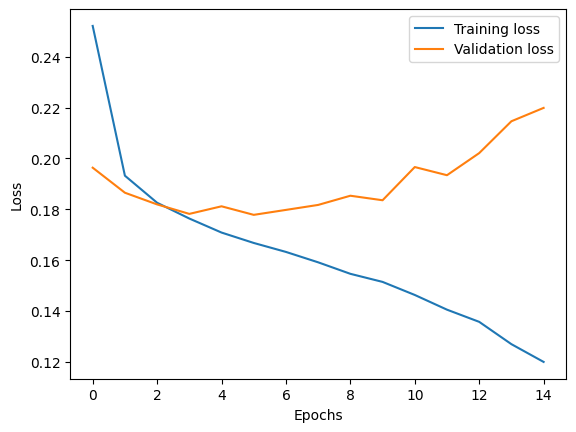

In [115]:
history = model.fit(training_data, training_labels, epochs=15, batch_size=batch_size, 
                    validation_data=(validation_data, validation_labels),
                    validation_batch_size=1000, 
                    verbose = True
                   )
# If you interrupt the above training this won't be redefined.
plot_losses(history)

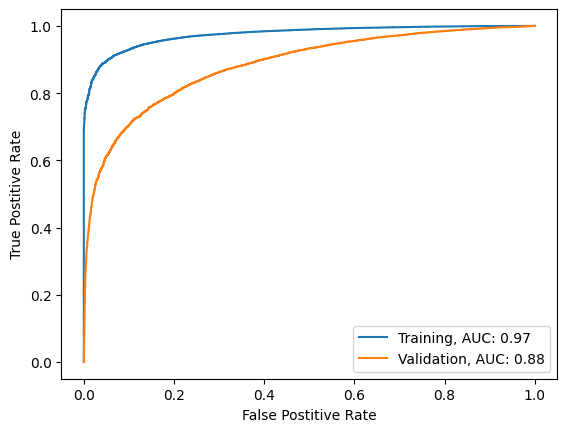

In [116]:
# You can also pass a batch size argument to the model predictions, this will speed up the computation
train_predictions = model.predict(training_data, batch_size=1000)
valid_predictions = model.predict(validation_data, batch_size=1000)

plot_roc(train_predictions, training_labels.to_numpy(), label='Training')
plot_roc(valid_predictions, validation_labels.to_numpy(), label='Validation')
plt.show()
plt.clf()

And here we can see a classic example of overfitting! The training loss is now lower than the validation loss, and that means our classifier does not perform as well on the validation dataset. From the AUC scores we can see this is reflected in the performance of the classifier, our model performs very well on the training dataset, but not as well on the validation dataset. The validation dataset shows us the kind of performance we can expect from our model when it is applied to real world data.

In some settings overfitting can be very difficult to get rid of, and we will look at more sophisticated methods for dealing with this later in this course. For now, try to reduce the capacity/number of parameters in the classifier. With less capacity the model loses some of its ability to 'memorise' specific training examples, and so has to learn how to generalise. 
Smaller models are also much faster/easier to train and evaluate, which is also very important in real world examples!

The batch size and learning rate also have an important impact on the performance of the model. How high can you get the AUC?

Now we have tuned our classifier to optimise the performance on the validation dataset. But, how do we know that this model will generalise well to yet more data? By choosing our model parameters based on the validation data we can overfit to the validation dataset! That is why we typically have a third heldout dataset which we can use to validate the performance of the model, we will come back to this in later lessons.

## Extension: Backpropogation

In this section we will go through a bit more of the technical aspects of what we have been doing so far.

The tensorflow API offers several levels of abstraction. What we have just walked through is the highest level, and it removes the need to get your hands dirty working with the nuts and bolts of the underlying computations. We don't want to go too low level, but it is instructive (and often easier) to be more explicit with the definitions of both the training and network design. 

In the following we will walk through some of the steps that happen under the hood of the ```model.fit``` method we have been using so far. This is where a lot of the magic happens in machine learning methods, and it is very useful to be able to control exactly how these steps are performed. This will also bring us closer to how Pytorch is used, for those who are following the course using this framework.

Custom training loops in tensorflow are built using the [GradientTape](https://www.tensorflow.org/api_docs/python/tf/GradientTape) context manager, and we will demonstrate it's use in the following.

In [117]:
# Gradient tape version of tensorflow API

# We can build our model in exactly the same way as before
activation='relu'
n_layers = 3
learning_rate = 1e-3
n_hidden_nodes = 64

inputs = tf.keras.Input(shape=(training_data.shape[1],))
x = Dense(n_hidden_nodes, activation=activation)(inputs)
for _ in range(n_layers):
    x = Dense(n_hidden_nodes, activation=activation)(x)
outputs = Dense(1, activation='sigmoid')(x)
model = Model(inputs=inputs, outputs=outputs)

# We will also define and use an optimizer the same way we did earlier
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

In [118]:
# Now things start to be a bit different, here we define a loss object
bce = tf.keras.losses.BinaryCrossentropy()
# This object is callable, it returns the error in each of our predictions.
# Let's see what happens when we call this object on a perfect prediction
print(bce(
    [0., 1.], # This is our true labels
    [0., 1.]  # This is our 'prediction'
   ).numpy())

0.0


In [119]:
# This is the lower bound of the binary cross entropy, and is the performance a perfect classifier would achieve.
# Now what about perfectly incorrect labels
print(bce([0., 1.], [1., 0.]).numpy())
# Much larger! The goal of training our models is to reduce the the value of this loss function.

15.379093


In [120]:
# Note how this loss value is independent of the number of samples we pass to our loss object.
# This is because the loss is the mean value of each prediction
print(bce([0., 1., 0., 1.], [1., 0., 1., 0.]).numpy())

15.379093


In [121]:
# What about being completely uncertain of the labels/guessing randomly?
print(bce([0., 1.], [0.5, 0.5]).numpy())
# This gives a faniliar value of ln(2)
print(np.log(2))
# Your classifier should never do worse than this, otherwise it is doing worse than guessing randomly!

0.69314694
0.6931471805599453


In [122]:
# Let's see how our model performs at 'initialization', ie) when the parameters of our neural 
# network have been sampled randomly. Some parameters have to be chosen to define our initial model, and sampling
# them randomly is a good way to do that. Different ways of sampling these weights is an active area of research,
# but not something we need to be concerned with in almost all settings.
print(bce(training_labels.to_numpy(), model(training_data.to_numpy())[:, 0]))

tf.Tensor(0.7243669, shape=(), dtype=float32)


So now we have investigated our loss function, it's time to update the weights of our model to improve our predictions. For this we will be using gradient tape.

Below is a large block of code, but don't be put off by this, each of the steps should be simple and easy to follow.

In [123]:
# Define an index to count how many times the cell below this has been run
i = 0

In [124]:
# Define the number of samples we will use in a batch.
batch_size = 64
# Take a batch of data
batch_of_data = training_data.to_numpy()[i * batch_size: (i + 1) * batch_size]
# Get the corresponding labels for the above batch
labels_of_batch = training_labels.to_numpy()[i * batch_size: (i + 1) * batch_size]
# Open the gradient tape context manager to start tracking the gradients, and define the variable tape
# The weights in a keras model object will be automatically tracked in this context manager.
with tf.GradientTape() as tape:
    # Call the model on our (mini)batch of data to get the predictions of the model in it's current state
    predictions = model(batch_of_data)[:, 0]
    # Calculate the loss on our batch of data.
    loss = bce(labels_of_batch, predictions)
    print(f'Loss on training data before update {loss:.2f}') 

# Use the tape variable to retrieve the derivatives of the loss with respect to the parameters of the model.
gradients = tape.gradient(loss, model.trainable_weights)
# Use the optimizer to do the chain rule and update the parameters in our neural network model.
optimizer.apply_gradients(zip(gradients, model.trainable_weights))

# Now the model has gone through one gradient update, we can see that the model predictions have improved by 
# recalculating the loss on the same data
predictions = model(batch_of_data)[:, 0]
print(f'Loss on training data after update {bce(labels_of_batch, predictions):.2f}')
# Recalculating the loss on the training data doesn't tell us much about the models performance, as these points 
# have been used to calculate the derivatives of the model, it's more interesting to see how the model generalises
# to data points it has never seen before. For this we use the validation data. Remember that, if the model isn't
# defined carefully, the validation loss will be very different to the training loss.
validation_batch = validation_data.to_numpy()[:batch_size]
validation_predictions = model(validation_batch)[:, 0]
validation_batch_labels = validation_labels.to_numpy()[:batch_size]
print(f'Loss on validation data {bce(validation_batch_labels, validation_predictions):.2f}')
print(f'Trained for {i} epochs.')


# Increment the count, in case you want to run the cell again this will ensure a new batch of data is selected
i += 1

Loss on training data before update 0.71
Loss on training data after update 0.66
Loss on validation data 0.69
Trained for 0 epochs.


The tensorflow API offers lots of different functionality, for example we can customise the ```model.fit``` method  to perform custom [training steps](https://www.tensorflow.org/guide/keras/customizing_what_happens_in_fit) while having access to all the nice features of the ```.fit``` method. Take a look at the documentation for [tf.keras.Model](https://www.tensorflow.org/api_docs/python/tf/keras/Model) and [tf.data.Data](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) for some useful classes and guides for working with tensorflow. Most of the time the tf.data.Data part of the API is only needed if you want high performance from your training loops. On the other hand, inheriting from tf.keras.Model is very useful. Look through the docs we have linked in this cell and have a go at defining your own tensorflow model with a custom ```train_step```, then train this model on the dataset we have been using so far!

It's important to be able to use the documentation to figure out how to do new things, but don't worry if you get stuck. Any questions, from inheritance to how this implementation functions, let us know!